In [110]:
print('#########################')
print('Importing required packages ')
print('#########################')

#Importing required packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model
import statsmodels.api as sm
import pickle
from scipy.stats import rankdata
import smtplib
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import logging
from sklearn import metrics
from imblearn.over_sampling import SMOTE

#########################
Importing required packages 
#########################


In [2]:
data=pd.read_csv('Train_spray_weather_v1.csv')
data.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,GR,HZ,NO_EVENT,RA,SN,SQ,TS,TSRA,VCFG,VCTS
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,...,0,1,0,0,0,0,0,0,0,0
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,...,0,1,0,0,0,0,0,0,0,0


### Dropping Few Columns before buidling a model

In [3]:
df_final = data.drop(['NumMosquitos',
                   'Address',
                   'AddressNumberAndStreet',
                   'Street','Date','Block','CodeSum_Station','AddressAccuracy','BCFG','BR',
                     'DZ',
                     'FG',
                     'FGplus_',
                     'FU',
                     'GR',
                     'HZ',
                     'NO_EVENT',
                     'RA',
                     'SN',
                     'SQ',
                     'TS',
                     'TSRA',
                     'VCFG',
                     'VCTS'],axis=1)

### Creating a variable for length of day


In [4]:
df_final['Sunrise_Station'] = pd.to_datetime(df_final['Sunrise_Station'],format='%H:%M:%S')
df_final['Sunset_Station'] = pd.to_datetime(df_final['Sunset_Station'], format='%H:%M:%S')
df_final['length_of_day']=(df_final['Sunset_Station'] - df_final['Sunrise_Station']).dt.total_seconds()
df_final['length_of_day']=df_final['length_of_day'].astype(int)
df_final = df_final.drop(['Sunrise_Station', 'Sunset_Station'], axis=1)

### Original Distribution of dependent variable

In [66]:
print("WnvPresent",df_final.WnvPresent.value_counts(), sep='\n')

WnvPresent
0    8153
1     457
Name: WnvPresent, dtype: int64


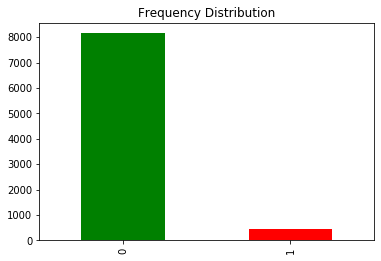

In [67]:
df_final["WnvPresent"].value_counts().plot(kind='bar',color=['green','red'],title="Frequency Distribution")

### Prep for model building

In [5]:
print('##################################')
print('Defining all input variables here ')
print('##################################')


# Input Dependant variable 
dep_var =  'WnvPresent'

# Input the thereshold for VIF
thresh = 2.0


# Input Variables which are neither dependant nor independant
species_var = 'Species'
Trap_var = 'Trap'
year_var = 'year'
month_var = 'month'
day_var = 'day'

##################################
Defining all input variables here 
##################################


### Identifying those variables that contribute to 90% of variation

In [54]:
# Running a ridge regression to identify the variables contributing at least 90% of the variation of the dependant variables

###### variable reduction based on ridge regression ########
print('########################################################################################')
print('Identifying those variables that explain 90% of the variation in the dependent variable ')
print('########################################################################################')

ind_var_aft_trans=list(df_final)
ind_var_aft_trans.remove(species_var)
ind_var_aft_trans.remove(dep_var)
ind_var_aft_trans.remove(Trap_var)

indepvar=pd.DataFrame()
indepvar = df_final[ind_var_aft_trans]
depvar = df_final[dep_var]

#  normalising the dataset before running ridge
indepvar_norm = (indepvar - indepvar.mean()) / indepvar.mean()

# Applying l2 penalty - ridge
lassoreg = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
lassoreg.fit(indepvar_norm,depvar)

col = list(indepvar) 
coef = pd.DataFrame(lassoreg.coef_,columns = col)
nonzero = coef.apply(lambda x: sum(x.values!=0),axis=1)
coeff_matrix_lasso_temp = coef.T.abs()
coeff_matrix_lasso_temp.columns=['coef']
# coeff_matrix_lasso=coeff_matrix_lasso_temp.sort('coef', ascending=False).head(20)

# Creating a dataframe to identify the most significant variables
lasso_coeffs=pd.DataFrame()
lasso_coeffs=coeff_matrix_lasso_temp.sort_values('coef', ascending=False)
lasso_coeffs.reset_index(level=0, inplace=True)
lasso_coeffs['cum_coef']=lasso_coeffs.coef.cumsum()
lasso_coeffs['perc_coeff']=lasso_coeffs.cum_coef/lasso_coeffs.coef.sum()

# Getting the list of variables which define 90% variation
total=len(lasso_coeffs[lasso_coeffs.perc_coeff<=0.90])

print("The Total no of variables explaning 90% of variation is "+str(total))

coeff_matrix_lasso=coeff_matrix_lasso_temp.sort_values('coef', ascending=False).head(min(total,nonzero[0]))

print('\nRigde done\n')
coll = coeff_matrix_lasso.index.tolist()
print("The variables remaining after ridge regression are:-")
print(coll)

########################################################################################
Identifying those variables that explain 90% of the variation in the dependent variable 
########################################################################################


/Users/sonal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The Total no of variables explaning 90% of variation is 18

Rigde done

The variables remaining after ridge regression are:-
['month', 'length_of_day', 'Cool_Station', 'WetBulb_Station_c', 'dist_2013-08-08 00:00:00', 'Tmin_Station', 'DewPoint_Station', 'dist_2011-09-07 00:00:00', 'trap_dist_st1', 'ResultSpeed_Station', 'WetBulb_Station', 'dist_2011-08-29 00:00:00', 'rel_hum_station', 'dist_2013-08-16 00:00:00', 'AvgSpeed_Station', 'Depart_Station', 'dist_2013-07-25 00:00:00', 'Station']


### Getting the individual sign of these variables

In [7]:
###### sign check ##################################

# To check if the variables change sign due to multi-collinearity among the independant variables
varlist = coll
df_final["intercept"] = 1.0
varlist.append('intercept')
for i in np.arange(0,len(varlist)):
    
    logits = sm.Logit(df_final.loc[:,dep_var], df_final[varlist]).fit()

    val =pd.concat((logits.params, abs(logits.tvalues)), axis=1)
    val.reset_index(level=0, inplace=True)
    val.columns=['variable','beta','tval']
    val.loc[val['beta'] >= 0, 'sign_final'] = '+'
    val.loc[val['beta'] < 0, 'sign_final'] = '-'

         Current function value: 0.181354
         Iterations: 35
         Current function value: 0.181354
         Iterations: 35
         Current function value: 0.181354
         Iterations: 35
         Current function value: 0.181354
         Iterations: 35
         Current function value: 0.181354
         Iterations: 35


/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed

         Current function value: 0.181354
         Iterations: 35
         Current function value: 0.181354
         Iterations: 35
         Current function value: 0.181354
         Iterations: 35
         Current function value: 0.181354
         Iterations: 35
         Current function value: 0.181354
         Iterations: 35


/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed

         Current function value: 0.181354
         Iterations: 35
         Current function value: 0.181354
         Iterations: 35
         Current function value: 0.181354
         Iterations: 35
         Current function value: 0.181354
         Iterations: 35
         Current function value: 0.181354
         Iterations: 35


/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed

         Current function value: 0.181354
         Iterations: 35
         Current function value: 0.181354
         Iterations: 35
         Current function value: 0.181354
         Iterations: 35
         Current function value: 0.181354
         Iterations: 35


/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/sonal/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [26]:
cols = list(val['variable'])
cols.remove('intercept')
cols

['month',
 'length_of_day',
 'Cool_Station',
 'WetBulb_Station_c',
 'dist_2013-08-08 00:00:00',
 'Tmin_Station',
 'DewPoint_Station',
 'dist_2011-09-07 00:00:00',
 'trap_dist_st1',
 'ResultSpeed_Station',
 'WetBulb_Station',
 'dist_2011-08-29 00:00:00',
 'rel_hum_station',
 'dist_2013-08-16 00:00:00',
 'AvgSpeed_Station',
 'Depart_Station',
 'dist_2013-07-25 00:00:00',
 'Station']

## Model 1 - Using scikit

In [49]:
print("Starting model training...")

#     # GET A TRAIN TEST SPLIT (set seed for consistent results)
training_data, testing_data = train_test_split(df_final,random_state = 2000,)

# GET LABELS
Y_train=training_data['WnvPresent'].values
Y_test=testing_data['WnvPresent'].values

X_train = training_data.loc[:, cols]
X_test = testing_data.loc[:, cols]

# INIT LOGISTIC REGRESSION CLASSIFIER
print("Training a Logistic Regression Model...",sep='\n')
scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)

model=scikit_log_reg.fit(X_train,Y_train)

# Confusion Matrix 
Y_Pred = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test, Y_Pred)
print("\n")
print("confusion matrix",sep='\n')
matrix

print(matrix)

# GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
print('\n')
print("Starting evaluation...")

print("Accuracy of the model: ",metrics.accuracy_score(Y_test, Y_Pred))


logging.info("Done training and evaluation.")



Starting model training...
Training a Logistic Regression Model...
[LibLinear]

confusion matrix
[[2050    0]
 [ 103    0]]


Starting evaluation...
Accuracy of the model:  0.9521597770552717


The value of AUC is  0.6818493961638645


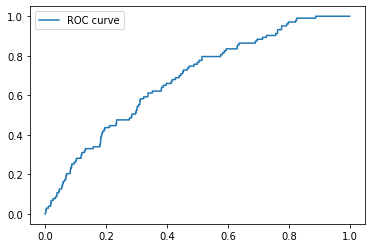

In [75]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="ROC curve")
print("The value of AUC is ",auc)
plt.legend(loc=2)
plt.show()

## Model 2 - Using statsmodels

In [79]:
#building a model using statsmodel library
logits = sm.Logit(training_data.loc[:,'WnvPresent'], training_data[cols]).fit()

Optimization terminated successfully.
         Current function value: 0.185916
         Iterations 9


In [80]:
#extracting the results of this model
def results_summary_to_df(results):
    pvals = results.pvalues
    coeff = results.params
    t_val = results.tvalues
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,"coeff":coeff,"t_val":t_val,"conf_lower":conf_lower,\
                               "conf_higher":conf_higher,"wald_chi_sq":t_val*t_val})

    #Reordering...
    results_df = results_df[["coeff","pvals","t_val","conf_lower","conf_higher","wald_chi_sq"]]
    return results_df

results_summary_to_df(logits)

,coeff,pvals,t_val,conf_lower,conf_higher,wald_chi_sq
month,0.426935,4.987416e-02,1.961042,0.000235,0.853636,3.845685
length_of_day,-0.000465,4.831834e-09,-5.852863,-0.000620,-0.000309,34.256000
Cool_Station,-0.045589,3.049141e-01,-1.025952,-0.132681,0.041503,1.052578
WetBulb_Station_c,0.677639,3.085025e-02,2.158999,0.062471,1.292808,4.661276
dist_2013-08-08 00:00:00,0.256193,8.724416e-02,1.710117,-0.037429,0.549815,2.924502
Tmin_Station,-0.004126,8.952771e-01,-0.131630,-0.065557,0.057306,0.017326
DewPoint_Station,0.040160,6.286645e-01,0.483607,-0.122600,0.202920,0.233876
dist_2011-09-07 00:00:00,-0.113172,5.138592e-01,-0.652840,-0.452938,0.226594,0.426201
trap_dist_st1,-0.168545,1.214753e-02,-2.507829,-0.300270,-0.036821,6.289209
ResultSpeed_Station,-0.118574,9.253574e-03,-2.602541,-0.207871,-0.029276,6.773220


In [74]:

print(logits.summary())

                           Logit Regression Results                           
Dep. Variable:             WnvPresent   No. Observations:                 6457
Model:                          Logit   Df Residuals:                     6439
Method:                           MLE   Df Model:                           17
Date:                Thu, 28 Nov 2019   Pseudo R-squ.:                  0.1250
Time:                        17:27:58   Log-Likelihood:                -1200.5
converged:                       True   LL-Null:                       -1372.0
Covariance Type:            nonrobust   LLR p-value:                 1.354e-62
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
month                        0.4269      0.218      1.961      0.050       0.000       0.854
length_of_day               -0.0005   7.94e-05     -5.853      0.000      -0.001      -0.

### Scoring

In [89]:
#scoring  customers based on the model created

param_order=pd.DataFrame(logits.params)
param_order.reset_index(level=0, inplace=True)
param_order_final=param_order['index'].tolist()

test_df=testing_data.reindex(columns=param_order_final)

test_df['intercept']=1.0 
test_df['pred']  = logits.predict(testing_data[cols])

pred_df = pd.concat((testing_data, test_df['pred']),axis = 1)
pred_df['decile'] = rankdata(pred_df.pred.values,method='ordinal')*10/(len(pred_df))
pred_df['decile']=np.ceil(pred_df['decile'])



# Getting AUC - Area undet the curve
scored_file = pred_df[['WnvPresent','pred']]
scored_file = scored_file.rename(columns={'WnvPresent': 'dep', 'pred': 'score'})

# sort the data by score
scored_file.sort_values(['score'], ascending=[True],inplace = True)

# get the rank by score
scored_file['decile'] = rankdata(scored_file.score,method='ordinal')

# logic to calculate mean rank for same prob scores
scored_file_mean = scored_file[['score','decile']]
scored_file_mean_fl = scored_file_mean['decile'].groupby(scored_file_mean.score).mean()
mean_rank=pd.DataFrame(scored_file_mean_fl)
mean_rank['index1'] = mean_rank.index
mean_rank = mean_rank.rename(columns={'decile': 'decile_new'})
mean_rank = mean_rank.reset_index(drop = True)

# merge it back to the base file to get the mean ranks
test = pd.merge(scored_file, mean_rank, left_on = 'score', right_on = 'index1', how='left')[['dep','score','decile_new']]

# get counts by dependent
dep = scored_file[['dep']]
dep['N']=1
dep = dep['N'].groupby(dep.dep).sum()
dep_fl = pd.DataFrame(dep)
dep_fl['Class'] = dep_fl.index
dep_fl_1 = dep_fl.reset_index(drop = True)

# sum of deciles

# get counts by dependent
dep = test[['dep','decile_new']]

dep = dep['decile_new'].groupby(dep.dep).sum()
dep_fl = pd.DataFrame(dep)
dep_fl['Class'] = dep_fl.index
dep_fl_2 = dep_fl.reset_index(drop = True)

# overall number of rows
dep_fl_1['sum_N'] = dep_fl_1['N'].sum()
dep_fl_1['ExpectedSum']= (dep_fl_1.N*(dep_fl_1.sum_N + 1))/2

# merge the two tables to get one single tabe
dep_fl_3 = pd.merge(dep_fl_1, dep_fl_2, left_on = 'Class', right_on = 'Class', how='inner')
multi = dep_fl_3[['N']]
multi['prod'] = multi['N'].product()
multi = multi[['prod']]
dep_fl_3 = dep_fl_3.join(multi, how = 'inner', lsuffix='_x')
dep_fl_3['gini'] = abs(dep_fl_3.decile_new - dep_fl_3.ExpectedSum)/dep_fl_3['prod']
dep_fl_3['AUC'] = (dep_fl_3.gini + 0.50)
AUC = dep_fl_3[['AUC']]
AUC_new = AUC.head(1)



print ("The AUC  is " ,dep_fl_3['AUC'][0])

The AUC  is  0.7763461993843239


/Users/sonal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sonal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [96]:
matrix = pd.crosstab(scored_file.WnvPresent,scored_file.pred)
matrix

pred,0.000047,0.000058,0.000092,0.000095,0.000096,0.000099,0.000102,0.000102,0.000103,0.000106,...,0.259107,0.261695,0.265594,0.274113,0.276535,0.286364,0.288084,0.316435,0.368941,0.410664
WnvPresent,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [104]:
import numpy as np
threshold = 0.5
pred = np.array(logits.predict(testing_data[cols]) > threshold, dtype=float)
table = np.histogram2d(testing_data.WnvPresent, pred, bins=2)[0]
table

array([[   0., 2050.],
       [   0.,  103.]])

In [105]:
matrix = pd.crosstab(testing_data.WnvPresent,scored_file.pred)
matrix

pred,0.000047,0.000058,0.000092,0.000095,0.000096,0.000099,0.000102,0.000102,0.000103,0.000106,...,0.259107,0.261695,0.265594,0.274113,0.276535,0.286364,0.288084,0.316435,0.368941,0.410664
WnvPresent,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


### Model 3 - with SMOTE

In [113]:
smt = SMOTE()
X_trainnew, Y_trainnew = smt.fit_sample(X_train, Y_train)

bincount : [6103 6103]


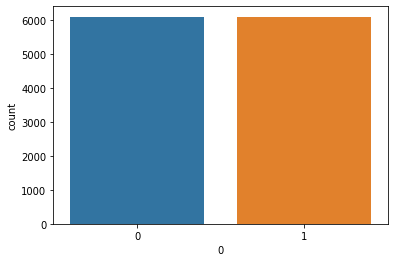

In [134]:
sns.countplot(x = 0, data=pd.DataFrame(Y_trainnew))
print("bincount :",np.bincount(Y_trainnew))

In [114]:
# INIT LOGISTIC REGRESSION CLASSIFIER
print("Training a Logistic Regression Model...",sep='\n')
scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)

model=scikit_log_reg.fit(X_trainnew,Y_trainnew)

# Confusion Matrix -- To be run for k=2
Y_Pred = model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test, Y_Pred)
print("\n")
print("confusion matrix",sep='\n')
matrix

print(matrix)

# GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
print('\n')
print("Starting evaluation...")

print("Accuracy of the model: ",metrics.accuracy_score(Y_test, Y_Pred))


logging.info("Done training and evaluation.")

Training a Logistic Regression Model...
[LibLinear]

confusion matrix
[[1284  766]
 [  27   76]]


Starting evaluation...
Accuracy of the model:  0.6316767301439852


The value of AUC is  0.7712124082405872


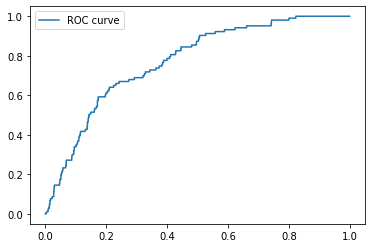

In [115]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="ROC curve")
print("The value of AUC is ",auc)
plt.legend(loc=2)
plt.show()